# Categorical Variables

In this tutorial, you will learn what a categorical variable is, along with three approaches for handling this type of data.

Introduction
A categorical variable takes only a limited number of values.

* Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.
* If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford". In this case, the data is also categorical.
You will get an error if you try to plug these variables into most machine learning models in Python without preprocessing them first. In this tutorial, we'll compare three approaches that you can use to prepare your categorical data.

## Three Approaches


### 1) Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.



### 2) Ordinal Encoding
Ordinal encoding assigns each unique value to a different integer.

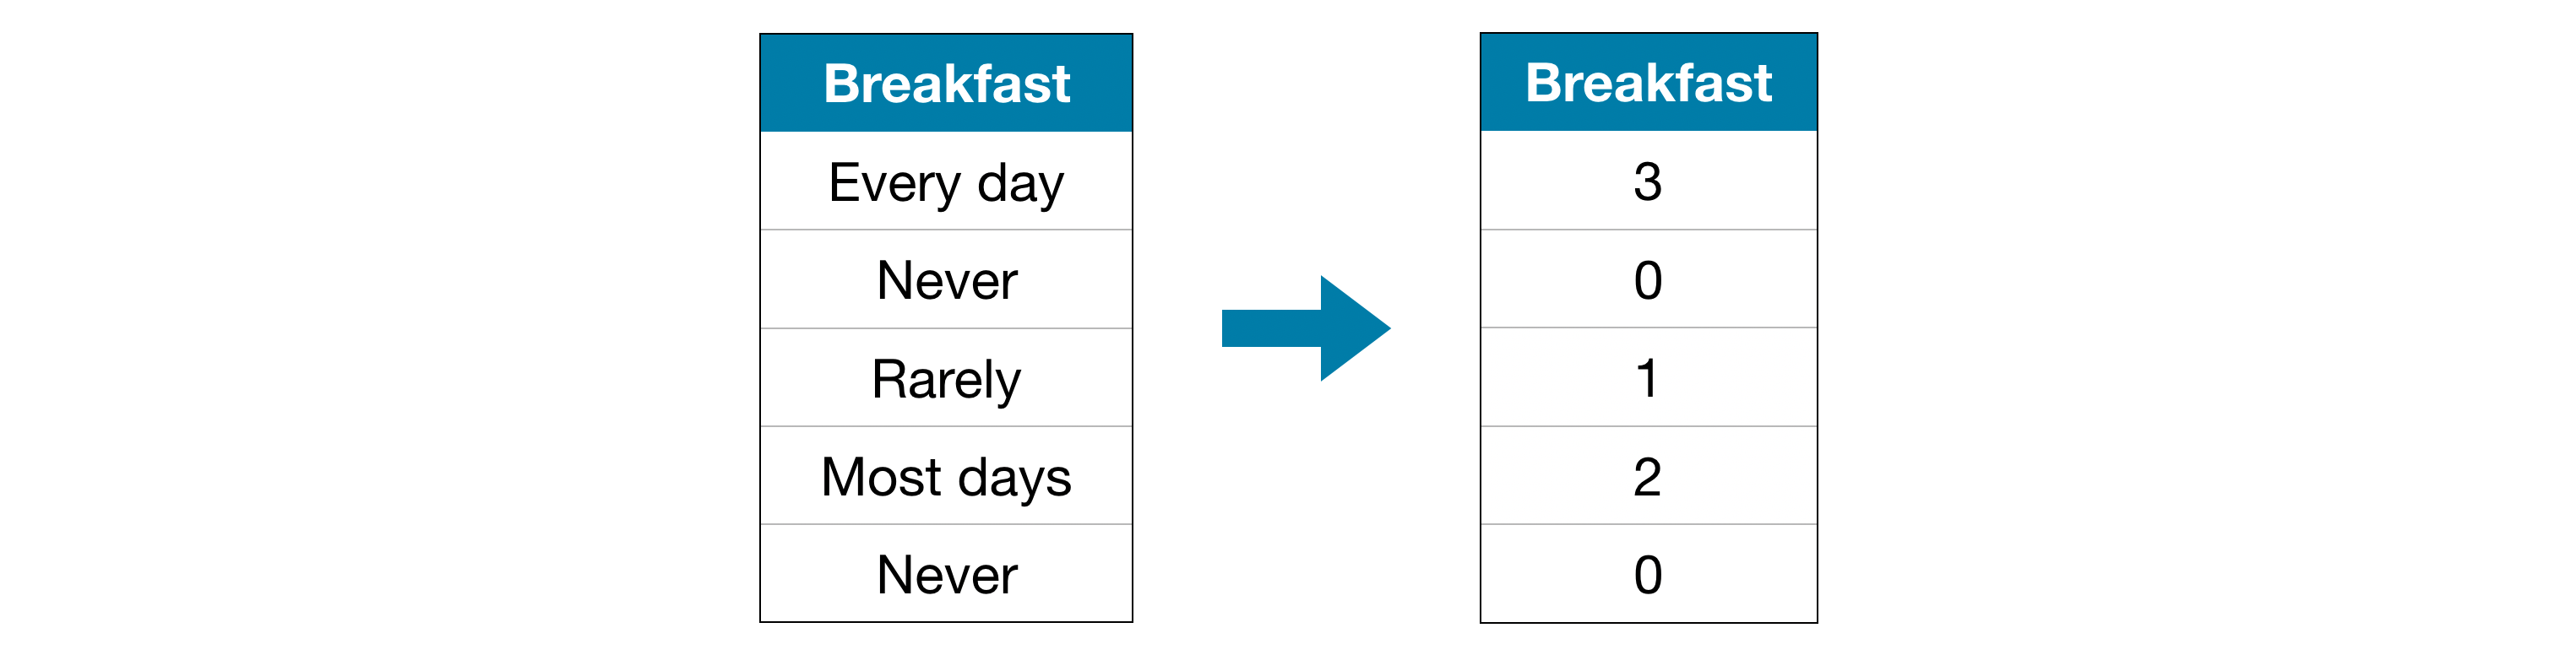

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

### 3) One-Hot Encoding
One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

tut3_onehot

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

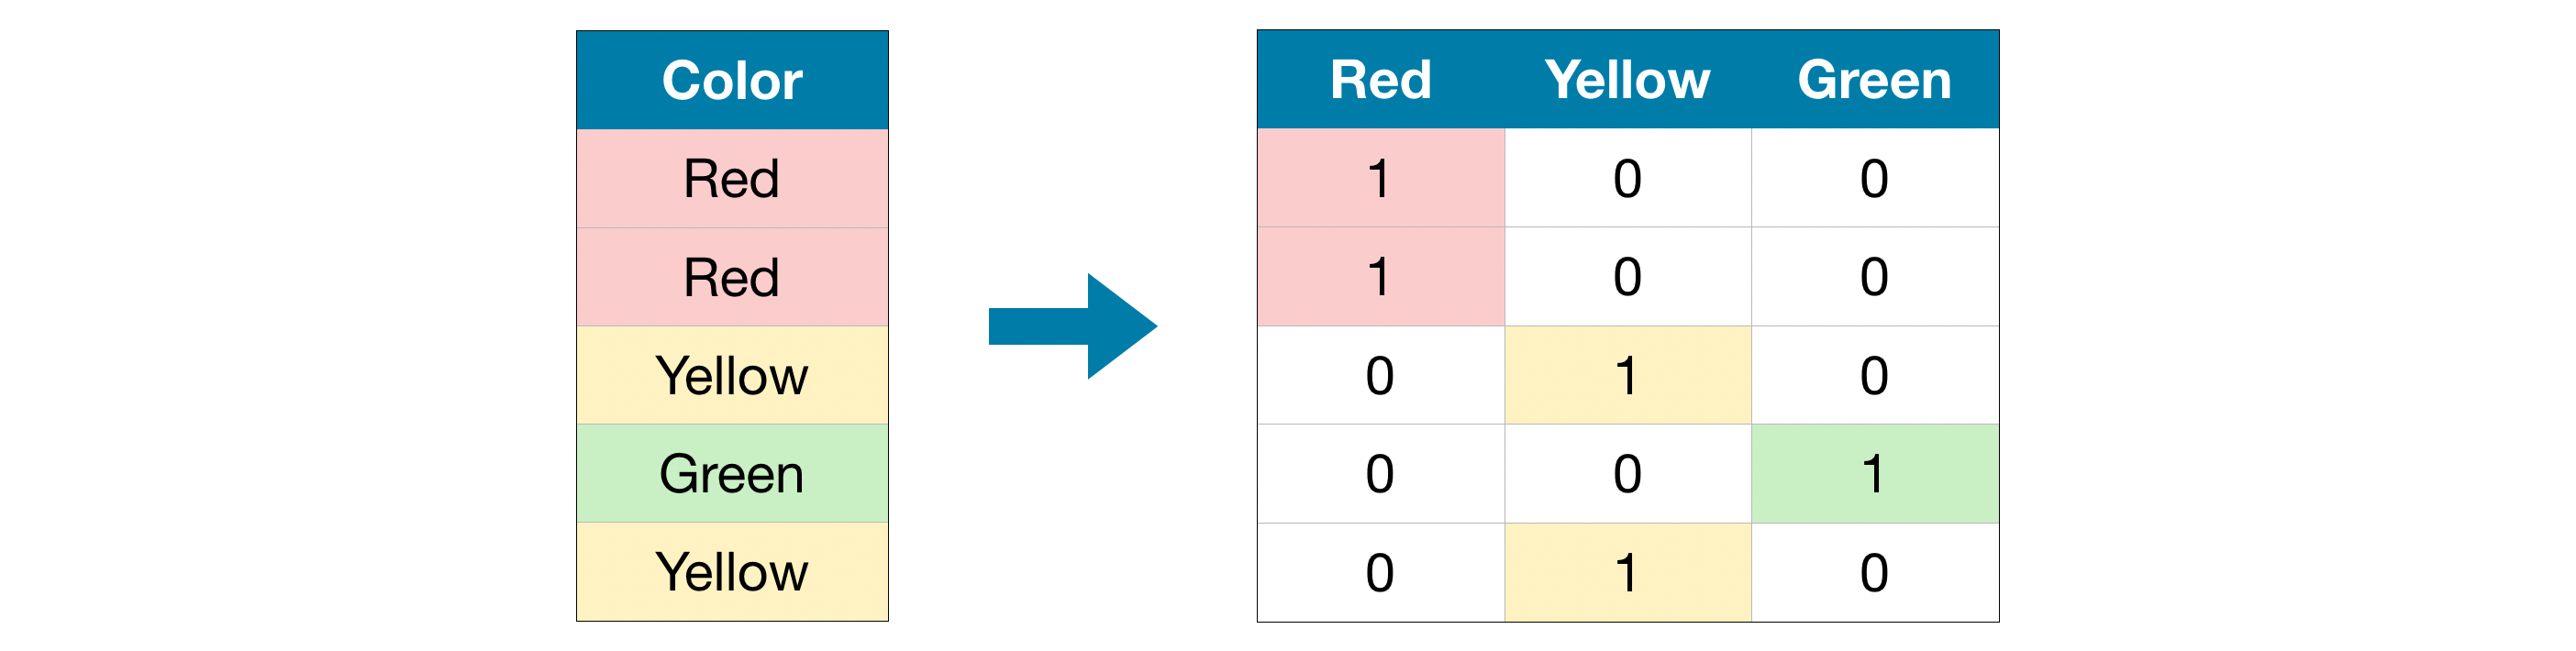

## Example
As in the previous tutorial, we will work with the Melbourne Housing dataset.

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the training and validation data in X_train, X_valid, y_train, and y_valid.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('/content/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()]
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_train.head(5)

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Next, we obtain a list of all of the categorical variables in the training data.

We do this by checking the data type (or dtype) of each column. The object dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes). For this dataset, the columns with text indicate categorical variables.

In [3]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


### Define Function to Measure Quality of Each Approach
We define a function score_dataset() to compare the three different approaches to dealing with categorical variables. This function reports the mean absolute error (MAE) from a random forest model. In general, we want the MAE to be as low as possible!

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Categorical Variables)
We drop the object columns with the select_dtypes() method.

In [5]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


### Score from Approach 2 (Ordinal Encoding)
Scikit-learn has a OrdinalEncoder class that can be used to get ordinal encodings. We loop over the categorical variables and apply the ordinal encoder separately to each column

In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165936.40548390493


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

### Score from Approach 3 (One-Hot Encoding)
We use the OneHotEncoder class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented in the training data, and
setting sparse=False ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

To use the encoder, we supply only the categorical columns that we want to be one-hot encoded. For instance, to encode the training data, we supply X_train[object_cols]. (object_cols in the code cell below is a list of the column names with categorical data, and so X_train[object_cols] contains all of the categorical data in the training set.)

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):")
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


### Which approach is best?
In this case, dropping the categorical columns (Approach 1) performed worst, since it had the highest MAE score. As for the other two approaches, since the returned MAE scores are so close in value, there doesn't appear to be any meaningful benefit to one over the other.

In general, one-hot encoding (Approach 3) will typically perform best, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis

### Conclusion
The world is filled with categorical data. It is a much more effective approach for data scientists to know how to use this common data type.